In [1]:
WORKING_DIR = "/home/xavier/Documents/DAE_project"

# Reconstruct images with different hyper parameters

In [2]:
import pandas as pd
import os
import shutil

IMG_DIR = f"{WORKING_DIR}/dataset/Roy_training/images"
container = []

for strain in os.listdir(IMG_DIR):
    run_id = int(strain.split("Run")[1])
    strain_path = os.path.join(IMG_DIR, strain)
    for scope in os.listdir(strain_path):
        scope_path = os.path.join(strain_path, scope)
        container.append([run_id, int(scope[-2:]), scope_path])
container = pd.DataFrame(container, columns=["Run", "Scope", "Directory"])

LABEL_DIR = f'{WORKING_DIR}/dataset/Roy_training/Caro_3d_9.7.22_2.20_new.xlsx'

label_df = pd.read_excel(LABEL_DIR)

annotated_container = pd.merge(container, label_df, on="Run")

OUT_DIR = f"{WORKING_DIR}/images/sup_figure2"
selected_dir = os.path.join(OUT_DIR, "targets")
os.makedirs(selected_dir, exist_ok=True)
SELECTED_FRAMES = [1441]
selected_strains = [1622, 8615, 2232, 4398, 4299, 5208, 4408]
filtered_df = annotated_container[
    annotated_container["Mutant #"].astype(str).apply(
        lambda x: any(str(s) in x for s in selected_strains)
    )
]
for _, row in filtered_df.iterrows():
    images = os.listdir(row["Directory"])
    name_format = images[0][:-8] + "%04d.jpg"
    for selected_frame in SELECTED_FRAMES:
        try:
            shutil.copy(os.path.join(row["Directory"], name_format % selected_frame),
                        os.path.join(selected_dir, f"{row['Mutant #']}_" + name_format % selected_frame))
        except FileNotFoundError:
            print(f"{selected_frame} not found in {row['Directory']}")

1441 not found in /home/xavier/Documents/DAE_project/dataset/Roy_training/images/CS2_44_1622_1%agar_Run0320/Scope23
1441 not found in /home/xavier/Documents/DAE_project/dataset/Roy_training/images/CS2_44_1622_1%agar_Run0320/Scope22
1441 not found in /home/xavier/Documents/DAE_project/dataset/Roy_training/images/CS2_44_1622_1%agar_Run0320/Scope24


## Manually select targets and put into the selected_targets folder

In [17]:
# Helper functions
import os
import cv2
import numpy as np
import pandas as pd
import torch
import dnnlib
import legacy
import pickle as pkl
from multiprocessing import Pool
import functools
from training.networks_stylegan2 import SynthesisLayer, MinibatchStdLayer

os.environ['CC'] = "/usr/bin/gcc-9"
os.environ['CXX'] = "/usr/bin/g++-9"

device = torch.device('cuda')


def reset_noise_const(G, seed):
    torch.manual_seed(seed)

    for block in G.synthesis.children():
        for layer in block.children():
            if layer.__class__.__name__ == "SynthesisLayer":  #isinstance(layer, SynthesisLayer):
                resolution = layer.resolution

                with torch.no_grad():
                    layer.noise_const.copy_(torch.randn([resolution, resolution]))


def resize_crop(img_name, resize_by=1., resolution=512, brightness_norm=True, brightness_mean=107):
    img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    if img.dtype != np.uint8:
        img = np.uint8(img / 256)
    img_shape = img.shape
    resize_shape = np.array([img_shape[1] * resize_by, img_shape[0] * resize_by], dtype=int)
    if resize_by != 1:
        img = cv2.resize(img, resize_shape, cv2.INTER_LANCZOS4)
    img = img[(resize_shape[1] - resolution) // 2:(resize_shape[1] + resolution) // 2,
    (resize_shape[0] - resolution) // 2:(resize_shape[0] + resolution) // 2]
    if brightness_norm:
        obj_v = np.mean(img)
        value = brightness_mean - obj_v
        img = cv2.add(img, value)
    return img


def load_and_patch_model(pkl_path):
    """Loads the StyleGAN2 model, patching it if necessary for feature extraction."""
    patched_pkl_path = pkl_path.replace('.pkl', '-patched.pkl')
    if os.path.exists(patched_pkl_path):
        print(f"Loading already patched model from: {patched_pkl_path}")
        with dnnlib.util.open_url(patched_pkl_path) as fp: return legacy.load_network_pkl(fp)
    print(f"Loading original model from: {pkl_path}")
    with dnnlib.util.open_url(pkl_path) as fp:
        models = legacy.load_network_pkl(fp)
    E_ema = models['E_ema']
    # The patch ensures MinibatchStdLayer is present.
    if not hasattr(E_ema.b4.get_mu, 'mbstd') or not isinstance(E_ema.b4.get_mu.mbstd, MinibatchStdLayer):
        print("Model needs patching...")
        E_ema.b4.get_mu.mbstd = MinibatchStdLayer(group_size=4).eval()
        E_ema.b4.get_logvar.mbstd = MinibatchStdLayer(group_size=4).eval()
        with open(patched_pkl_path, 'wb') as f_out:
            pkl.dump(models, f_out)
        print(f"Saved patched model to: {patched_pkl_path}")
    else:
        print("Model already patched.")
        if not os.path.exists(patched_pkl_path):
            with open(patched_pkl_path, 'wb') as f_out: pkl.dump(models, f_out)
    return models
                    

target_images = []
img_names = []
target_folder = os.path.join(OUT_DIR, "reconstructions/targets")
os.makedirs(target_folder, exist_ok=True)
for img_name in os.listdir(os.path.join(OUT_DIR, "selected_targets")):
    target_image = resize_crop(os.path.join(OUT_DIR, "selected_targets", img_name))
    target_images.append(target_image)
    img_names.append(img_name)
    cv2.imwrite(os.path.join(target_folder, img_name), target_image)

# row1 = np.hstack(target_images[:4])  # First row
# row2 = np.hstack(target_images[4:8])  # Second row
# grid_image = np.vstack([row1, row2])  # Stack rows
# cv2.imwrite(os.path.join(OUT_DIR, "reconstructions_none", f"target.png"), grid_image)
target_images = np.array(target_images)
target_images = torch.Tensor(target_images).to(device).to(torch.float32) / 127.5 - 1
target_images = target_images[:, None, :, :]

## Number of dimensions

In [6]:
ROOT_DIR = f"{WORKING_DIR}/models/others/"
model_dirs = {
    "e10-pre": "e10-pre/00000-stylegan2-pre-training-gpus4-batch112-gamma10",
    "e11-pre": "e11-pre/00002-stylegan2-pre-training-gpus4-batch112-gamma10",
    "e12-pre": "e12-pre/00001-stylegan2-pre-training-gpus4-batch112-gamma10",
    "e13-pre": "e13-pre/00002-stylegan2-pre-training-gpus4-batch112-gamma10",
    "e13": "e13/00001-stylegan2-trainingset2-gpus4-batch96-gamma10",
    "e14-pre": "e14-pre/00001-stylegan2-pre-training-gpus4-batch112-gamma10",
    "e15-pre": "e15-pre/00000-stylegan2-pre-training-gpus4-batch112-gamma10"
}

for model_label in model_dirs:
    model_dir = os.path.join(ROOT_DIR, model_dirs[model_label], "network-snapshot-000252.pkl")
    reconstructed_dir = os.path.join(OUT_DIR, "reconstructions_none", model_label)
    os.makedirs(reconstructed_dir, exist_ok=True)
    models= load_and_patch_model(model_dir)
    E = models['E_ema'].to(device)
    G = models['G_ema'].to(device)  # type: ignore

    z, logvar = E.mu_var(target_images, None)
    for random_seed in [6, 26]:
        reset_noise_const(G, random_seed)
        reconstructed_images = G(z, None, noise_mode='const')
        reconstructed_images = (reconstructed_images + 1) * 127.5
        reconstructed_images = reconstructed_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:,
        :, :,
        0]
        for reconstructed_image, img_name in zip(reconstructed_images, img_names):
            cv2.imwrite(os.path.join(reconstructed_dir, f"{random_seed - 6}_{img_name}"), reconstructed_image)
        # row1 = np.hstack(reconstructed_images[:4])  # First row
        # row2 = np.hstack(reconstructed_images[4:8])  # Second row
        # grid_image = np.vstack([row1, row2])  # Stack rows
        # cv2.imwrite(os.path.join(OUT_DIR, "reconstructions_none", f"{random_seed}_{model_label}.png"), grid_image)

Loading already patched model from: /home/xavier/Documents/DAE_project/models/others/e10-pre/00000-stylegan2-pre-training-gpus4-batch112-gamma10/network-snapshot-000252-patched.pkl
Loading already patched model from: /home/xavier/Documents/DAE_project/models/others/e11-pre/00002-stylegan2-pre-training-gpus4-batch112-gamma10/network-snapshot-000252-patched.pkl
Loading already patched model from: /home/xavier/Documents/DAE_project/models/others/e12-pre/00001-stylegan2-pre-training-gpus4-batch112-gamma10/network-snapshot-000252-patched.pkl
Loading original model from: /home/xavier/Documents/DAE_project/models/others/e13-pre/00002-stylegan2-pre-training-gpus4-batch112-gamma10/network-snapshot-000252.pkl
Model needs patching...
Saved patched model to: /home/xavier/Documents/DAE_project/models/others/e13-pre/00002-stylegan2-pre-training-gpus4-batch112-gamma10/network-snapshot-000252-patched.pkl
Loading original model from: /home/xavier/Documents/DAE_project/models/others/e13/00001-stylegan2-

## Pre-training

In [10]:
model_dirs = {
    "e13-post": "e13-post/from302kimgs/00000-stylegan2-trainingset2-gpus4-batch112-gamma10",
    "e13-scratch": "e13-scratch/00000-stylegan2-trainingset2-gpus4-batch112-gamma10",
}

for model_label in model_dirs:
    model_dir = os.path.join(ROOT_DIR, model_dirs[model_label], "network-snapshot-001512.pkl")
    reconstructed_dir = os.path.join(OUT_DIR, "reconstructions_none", model_label)
    os.makedirs(reconstructed_dir, exist_ok=True)
    models= load_and_patch_model(model_dir)
    E = models['E_ema'].to(device)
    G = models['G_ema'].to(device)  # type: ignore

    z, logvar = E.mu_var(target_images, None)
    for random_seed in [6, 26]:
        reset_noise_const(G, random_seed)
        reconstructed_images = G(z, None, noise_mode='const')
        reconstructed_images = (reconstructed_images + 1) * 127.5
        reconstructed_images = reconstructed_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:,
        :, :,
        0]
        for reconstructed_image, img_name in zip(reconstructed_images, img_names):
            cv2.imwrite(os.path.join(reconstructed_dir, f"{random_seed - 6}_{img_name}"), reconstructed_image)
        # row1 = np.hstack(reconstructed_images[:4])  # First row
        # row2 = np.hstack(reconstructed_images[4:])  # Second row
        # grid_image = np.vstack([row1, row2])  # Stack rows
        # cv2.imwrite(os.path.join(OUT_DIR, "reconstructions_none", f"{model_label}.png"), grid_image)

Loading original model from: /home/xavier/Documents/DAE_project/models/others/e13-post/from302kimgs/00000-stylegan2-trainingset2-gpus4-batch112-gamma10/network-snapshot-001512.pkl
Model needs patching...
Saved patched model to: /home/xavier/Documents/DAE_project/models/others/e13-post/from302kimgs/00000-stylegan2-trainingset2-gpus4-batch112-gamma10/network-snapshot-001512-patched.pkl
Loading original model from: /home/xavier/Documents/DAE_project/models/others/e13-scratch/00000-stylegan2-trainingset2-gpus4-batch112-gamma10/network-snapshot-001512.pkl
Model needs patching...
Saved patched model to: /home/xavier/Documents/DAE_project/models/others/e13-scratch/00000-stylegan2-trainingset2-gpus4-batch112-gamma10/network-snapshot-001512-patched.pkl


## Ablation Study

In [18]:
model_dirs = {
    "e13_random": f"{WORKING_DIR}/models/ablation/run_e13_random/00000-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300.pkl",
    "e13_no_noise": f"{WORKING_DIR}/models/ablation/run_e13_no_noise/00001-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300.pkl",
    "e13_const": f"{WORKING_DIR}/models/ablation/run_e13_const/00001-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300.pkl"
}

for model_name, model_dir in model_dirs.items():
    reconstructed_dir = os.path.join(OUT_DIR, "ablation", model_name)
    os.makedirs(reconstructed_dir, exist_ok=True)
    models= load_and_patch_model(model_dir)
    E = models['E_ema'].to(device)
    G = models['G_ema'].to(device)  # type: ignore

    z, logvar = E.mu_var(target_images, None)
    reconstructed_images = G(z, None, noise_mode='none')
    reconstructed_images = (reconstructed_images + 1) * 127.5
    reconstructed_images = reconstructed_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
    for reconstructed_image, img_name in zip(reconstructed_images, img_names):
        cv2.imwrite(os.path.join(reconstructed_dir, f"none_{img_name}"), reconstructed_image)
    reconstructed_images = G(z, None, noise_mode='const')
    reconstructed_images = (reconstructed_images + 1) * 127.5
    reconstructed_images = reconstructed_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
    for reconstructed_image, img_name in zip(reconstructed_images, img_names):
        cv2.imwrite(os.path.join(reconstructed_dir, f"const_{img_name}"), reconstructed_image)
    for random_seed in [6, 26, 46]:
        reset_noise_const(G, random_seed)
        reconstructed_images = G(z, None, noise_mode='const')
        reconstructed_images = (reconstructed_images + 1) * 127.5
        reconstructed_images = reconstructed_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8).cpu().numpy()[:, :, :, 0]
        for reconstructed_image, img_name in zip(reconstructed_images, img_names):
            cv2.imwrite(os.path.join(reconstructed_dir, f"seed{random_seed}_{img_name}"), reconstructed_image)
        # row1 = np.hstack(reconstructed_images[:4])  # First row
        # row2 = np.hstack(reconstructed_images[4:])  # Second row
        # grid_image = np.vstack([row1, row2])  # Stack rows
        # cv2.imwrite(os.path.join(OUT_DIR, "reconstructions_none", f"{model_label}.png"), grid_image)

Loading already patched model from: /home/xavier/Documents/DAE_project/models/ablation/run_e13_random/00000-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300-patched.pkl
Loading already patched model from: /home/xavier/Documents/DAE_project/models/ablation/run_e13_no_noise/00001-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300-patched.pkl
Loading already patched model from: /home/xavier/Documents/DAE_project/models/ablation/run_e13_const/00001-stylegan2-pre-training-gpus4-batch80-gamma10/network-snapshot-000300-patched.pkl


# Ablation curves

Reading logs for e13_no_noise...
  > Loaded 50 tags. Max Step found: 466 -> 466.0 kimgs

--- DEBUG: Available Keys in e13_no_noise ---
  train_eval_Metrics/Acc@1
  train_eval_Metrics/Acc@5
  train_eval_Metrics/Acc@50
  train_eval_Metrics/MAP@1
  train_eval_Metrics/MAP@5
  train_eval_Metrics/MAP@50
  train_eval_Metrics/Recall@1
  train_eval_Metrics/Recall@5
  train_eval_Metrics/Recall@50
  validation_Metrics/Acc@1
  validation_Metrics/Acc@5
  validation_Metrics/Acc@50
  validation_Metrics/MAP@1
  validation_Metrics/MAP@5
  validation_Metrics/MAP@50
  validation_Metrics/Recall@1
  validation_Metrics/Recall@5
  validation_Metrics/Recall@50
--------------------------------------------

Reading logs for e13_const...
  > Loaded 50 tags. Max Step found: 768 -> 768.0 kimgs
Reading logs for e13_random...
  > Loaded 50 tags. Max Step found: 560 -> 560.0 kimgs
Plot saved to /home/xavier/Documents/DAE_project/images/sup_figure2/metrics_comparison.png


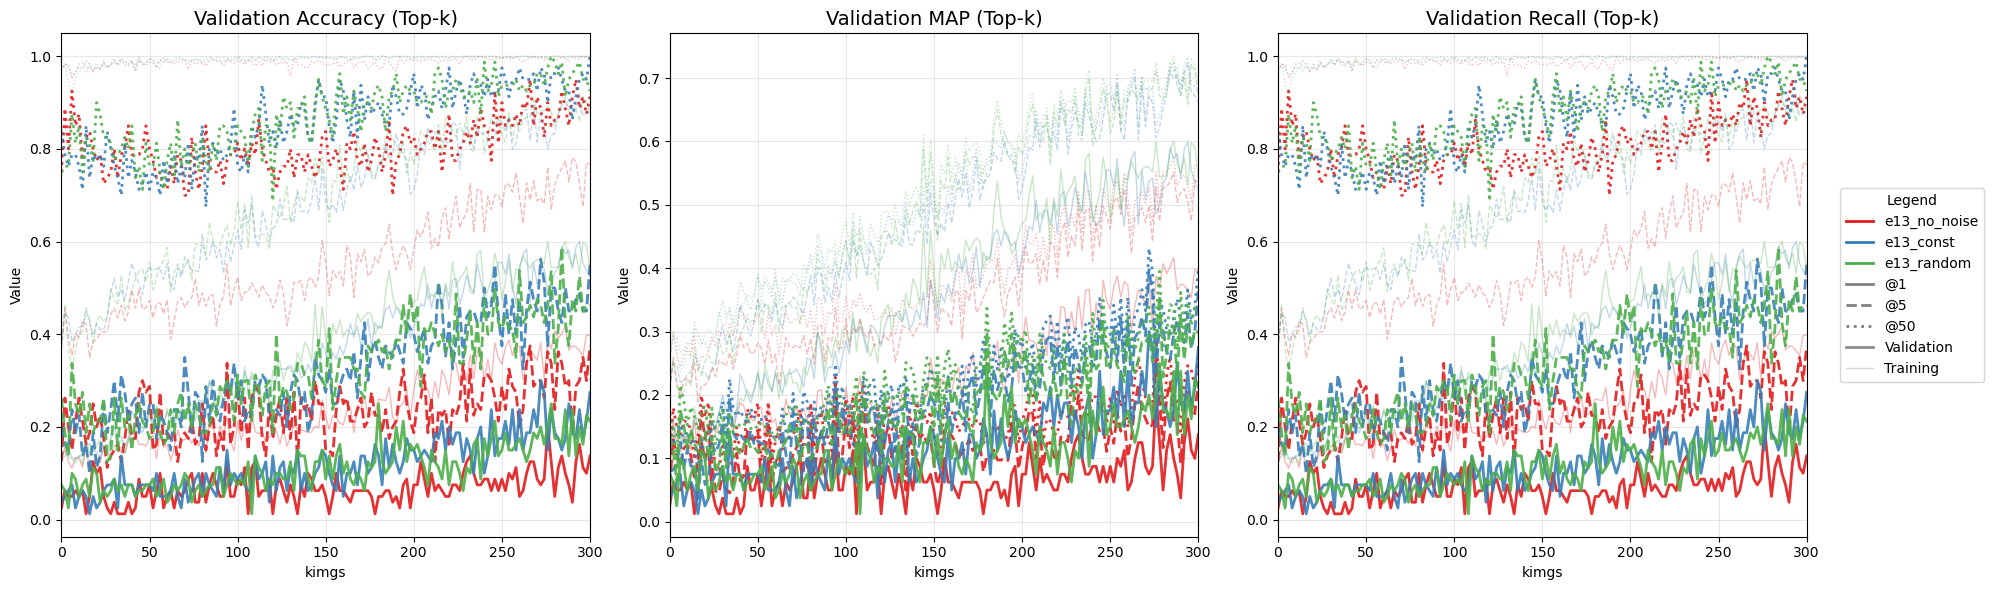

In [24]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

model_logs = {
    'e13_no_noise': f"{WORKING_DIR}/models/ablation/run_e13_no_noise/00001-stylegan2-pre-training-gpus4-batch80-gamma10/events.out.tfevents.1769769814.bc13u30n1.2137278.0",
    'e13_const': f"{WORKING_DIR}/models/ablation/run_e13_const/00001-stylegan2-pre-training-gpus4-batch80-gamma10/events.out.tfevents.1769894848.bc13u30n1.2251275.0",
    'e13_random': f"{WORKING_DIR}/models/ablation/run_e13_random/00000-stylegan2-pre-training-gpus4-batch80-gamma10/events.out.tfevents.1770013549.bc13u30n1.2350112.0"
}

# Whether to show Training Metrics
SHOW_TRAINING = True

# X-axis truncation limit (in kimgs)
X_LIMIT = 300

# Conversion factor: Set to 1.0 if 'step' in log is already kimgs (common in StyleGAN)
# Set to 1/1000.0 if 'step' is image count.
STEP_TO_KIMGS = 1.0 

# ===========================================

def read_tfevents(path):
    """
    Read tfevents file and return a dictionary of scalar data
    Also returns the raw tags list for inspection
    """
    if not os.path.exists(path):
        print(f"Warning: File not found: {path}")
        return None, []

    # Load logs, size_guidance={'scalars': 0} loads all scalars
    ea = EventAccumulator(path, size_guidance={'scalars': 0})
    ea.Reload()
    
    tags = ea.Tags()['scalars']
    data = {}
    
    max_step_found = 0

    for tag in tags:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        
        if len(steps) > 0:
            max_step_found = max(max_step_found, max(steps))

        # Convert step to kimgs based on factor
        kimgs = np.array(steps) * STEP_TO_KIMGS
        
        data[tag] = (kimgs, np.array(values))
    
    # Debug print for scaling check
    if max_step_found > 0:
        print(f"  > Loaded {len(tags)} tags. Max Step found: {max_step_found} -> {max_step_found * STEP_TO_KIMGS} kimgs")

    return data, tags

# ================= Main Logic (Notebook Style) =================

# Prepare plotting data structures
metric_groups = {
    'Accuracy': ['Acc@1', 'Acc@5', 'Acc@50'],
    'MAP': ['MAP@1', 'MAP@5', 'MAP@50'],
    'Recall': ['Recall@1', 'Recall@5', 'Recall@50']
}

# Define line styles to distinguish @1, @5, @50
line_styles = {
    '@1': '-',      # Solid
    '@5': '--',     # Dashed
    '@50': ':'      # Dotted
}

# Define colors to distinguish models
colors = ['#e41a1c', '#377eb8', '#4daf4a'] # Red, Blue, Green
model_colors = {name: color for name, color in zip(model_logs.keys(), colors)}

# Read all data
all_data = {}
first_model_tags = None

for model_name, path in model_logs.items():
    print(f"Reading logs for {model_name}...")
    data, tags = read_tfevents(path)
    all_data[model_name] = data
    
    # Save tags from the first successfully loaded model for inspection
    if first_model_tags is None and tags:
        first_model_tags = tags
        print(f"\n--- DEBUG: Available Keys in {model_name} ---")
        # Print keys containing 'Acc' or 'MAP' or 'Recall' to help user verify names
        relevant_keys = [t for t in tags if any(k in t for k in ['Acc', 'MAP', 'Recall'])]
        for key in sorted(relevant_keys):
            print(f"  {key}")
        print("--------------------------------------------\n")

# Start plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.subplots_adjust(wspace=0.25)

# Possible prefixes for metrics (add more if needed)
VALIDATION_PREFIXES = ["Validation_Metrics", "validation_Metrics", "eval_Metrics"]
TRAINING_PREFIXES = ["Training_Metrics", "training_Metrics", "train_eval_Metrics"]

def find_metric_key(base_suffix, available_keys, prefixes):
    """
    Try to find a key in available_keys that matches one of the prefixes + base_suffix
    """
    for prefix in prefixes:
        candidate = f"{prefix}/{base_suffix}"
        # Case insensitive match
        for key in available_keys:
            if key.lower() == candidate.lower():
                return key
    return None

for idx, (group_name, suffixes) in enumerate(metric_groups.items()):
    ax = axes[idx]
    ax.set_title(f"Validation {group_name} (Top-k)", fontsize=14)
    ax.set_xlabel("kimgs")
    ax.set_ylabel("Value")
    ax.set_xlim(0, X_LIMIT)
    ax.grid(True, alpha=0.3)

    for model_name, model_data in all_data.items():
        if model_data is None: continue
        
        color = model_colors[model_name]
        
        for suffix in suffixes:
            # Extract Top-k suffix (e.g., Acc@1 -> @1) for matching line style
            k_style = suffix.split('Acc')[-1].split('MAP')[-1].split('Recall')[-1]
            ls = line_styles.get(k_style, '-')
            
            # Find actual keys in the log
            real_val_key = find_metric_key(suffix, model_data.keys(), VALIDATION_PREFIXES)
            real_train_key = find_metric_key(suffix, model_data.keys(), TRAINING_PREFIXES)

            # --- Plot Validation (Thick lines) ---
            if real_val_key and real_val_key in model_data:
                x, y = model_data[real_val_key]
                mask = x <= X_LIMIT
                ax.plot(x[mask], y[mask], label=f"{model_name} Val {suffix}", 
                        color=color, linestyle=ls, linewidth=2, alpha=0.9)
            
            # --- Plot Training (Thin/Transparent lines) ---
            if SHOW_TRAINING and real_train_key and real_train_key in model_data:
                x, y = model_data[real_train_key]
                mask = x <= X_LIMIT
                ax.plot(x[mask], y[mask], label=f"{model_name} Train {suffix}" if False else None,
                        color=color, linestyle=ls, linewidth=1, alpha=0.3)

# Unified Legend
from matplotlib.lines import Line2D

# Model color legend
legend_elements = [Line2D([0], [0], color=c, lw=2, label=m) for m, c in model_colors.items()]
# Metric line style legend
legend_elements += [Line2D([0], [0], color='gray', lw=2, linestyle=ls, label=k) for k, ls in line_styles.items()]

if SHOW_TRAINING:
    legend_elements.append(Line2D([0], [0], color='gray', lw=2, alpha=0.9, label='Validation'))
    legend_elements.append(Line2D([0], [0], color='gray', lw=1, alpha=0.3, label='Training'))

# Place legend outside
axes[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), title="Legend")

plt.tight_layout()

# Save the plot
save_path = os.path.join(OUT_DIR, "metrics_comparison.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {save_path}")

plt.show()